<h1>CO<sub>2</sub> Emission Prediction of Sri Lanka using LSTM (Univariate)</h1>
<p>LSTM (Long Short-Term Memory) is a type of Recurrent Neural Network (RNN) architecture designed to efficiently capture and utilize long-term dependencies in <b>sequential data</b>. In this project, I will be developping an LSTM model to predict future CO<sub>2</sub> emission.</p>

<p>CO<sub>2</sub> emission data is a <b>Timeseries</b> dataset, which fits for sequential model perfectly.</p>

## Dataset
<p>I will be using CO<sub>2</sub> emission data set by country from <a href="https://www.kaggle.com/datasets/ulrikthygepedersen/co2-emissions-by-country" target="_blank">Kaggle</a></p>

<div class="alert alert-success">
    <h3>Table of content</h3>
    <ol>
        <li>
            <a href="#Technologies and tools">Technologies and tools</a>
        </li>
        <li><a href="#Load-Dataset">Load Dataset</a></li>
        <li><a href="#check_dimensions">Check dimensions of Data</a></li>
        <li><a href="#forward_prop">Implementing Forward Propagation</a></li>
        <li><a href="#compile_model">Compile the model</a></li>
        <li><a href="#summary_of_the_model">Summary of the model</a></li>
        <li><a href="#train_and_evaluation">Train and evaluation</a></li>
        <li><a href="#save_model">Save the model</a></li>
    </ol>
</div>

## Technologies and tools
1. TensorFlow
2. Keras
3. LSTM
4. Sequential Model

## Load Dataset

In [448]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import pickle
%matplotlib inline

In [405]:
df_full = pd.read_csv('co2_emissions_kt_by_country.csv')

In [406]:
df_full.head()

,country_code,country_name,year,value
0,ABW,Aruba,1960,11092.675
1,ABW,Aruba,1961,11576.719
2,ABW,Aruba,1962,12713.489
3,ABW,Aruba,1963,12178.107
4,ABW,Aruba,1964,11840.743


In [407]:
df_full['country_name'].unique()

array(['Aruba', 'Africa Eastern and Southern', 'Afghanistan',
       'Africa Western and Central', 'Angola', 'Albania', 'Andorra',
       'Arab World', 'United Arab Emirates', 'Argentina', 'Armenia',
       'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan',
       'Burundi', 'Belgium', 'Benin', 'Burkina Faso', 'Bangladesh',
       'Bulgaria', 'Bahrain', 'Bahamas, The', 'Bosnia and Herzegovina',
       'Belarus', 'Belize', 'Bermuda', 'Bolivia', 'Brazil', 'Barbados',
       'Brunei Darussalam', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada',
       'Central Europe and the Baltics', 'Switzerland', 'Chile', 'China',
       "Cote d'Ivoire", 'Cameroon', 'Congo, Dem. Rep.', 'Congo, Rep.',
       'Colombia', 'Comoros', 'Cabo Verde', 'Costa Rica',
       'Caribbean small states', 'Cuba', 'Curacao', 'Cayman Islands',
       'Cyprus', 'Czechia', 'Germany', 'Djibouti', 'Dominica', 'Denmark',
       'Dominican Republic', 'Algeria',
       'East Asia & Pacific (excluding

In [408]:
df = df_full[df_full['country_name']=='Sri Lanka']

## Data celanup

### Remove unwanted columns

In [409]:
df.head()

,country_code,country_name,year,value
7399,LKA,Sri Lanka,1960,2258.872
7400,LKA,Sri Lanka,1961,2335.879
7401,LKA,Sri Lanka,1962,2563.233
7402,LKA,Sri Lanka,1963,2533.897
7403,LKA,Sri Lanka,1964,2273.540


In [410]:
df.drop(['country_code', 'country_name'], axis=1, inplace=True)

C:\Users\navilog\AppData\Local\Temp\ipykernel_3408\3515826104.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['country_code', 'country_name'], axis=1, inplace=True)


In [411]:
df.reset_index(drop=True, inplace=True)

In [412]:
df.head()

,year,value
0,1960,2258.872
1,1961,2335.879
2,1962,2563.233
3,1963,2533.897
4,1964,2273.540


In [487]:
df_year = df['year'].tail(1)
int(df_year)

2019

### check for null values

In [414]:
df.isna().sum()

year     0
value    0
dtype: int64

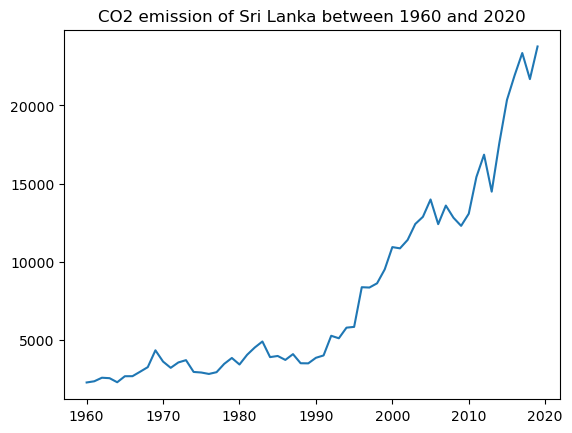

In [415]:
plt.plot(df['year'], df['value'])
plt.title('CO2 emission of Sri Lanka between 1960 and 2020')
plt.show()

<div class="alert alert-info">
    <h3>Observations:</h3>
    <ol>
        <li>Between 1960 and mid 90s the carbon emission was not much increased.</li>
        <li>After that, it has increased rapidly.</li>
    </ol>
</div>

## Data Preprocessing
In the data preprocessing stage I will be performing following things.
- filter the CO2 emission value column from the dataset
- rearrange the CO2 emission values and prepare a supervised learning dataset.
- reshape prepared dataset for LSTM model

In [416]:
df_co2 = df['value']
#df_co2

In [417]:
df_co2.describe()

count       60.000000
mean      7945.101660
std       6161.212232
min       2258.872000
25%       3440.562750
50%       4409.567500
75%      12402.499676
max      23780.000687
Name: value, dtype: float64

Above descriptive statistics shows that min and max values quite apart each other. Deep Learning prefers scaled data.
## Data scaling
In the dataset we have all positive values. I will use **Min-Max** scaler in the range of 0 and 1.

In [418]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(np.array(df_co2).reshape(-1, 1))

<IPython.core.display.Javascript object>

## Save scaler and original emission values for future use

In [450]:
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [452]:
df[['year', 'value']].to_csv('year_emission.csv', index=False)

### Split dataset into train / validation sets

In [419]:
train_size = int(len(df_scaled) * 0.70)
val_size = len(df_scaled) - train_size

train_size, val_size

(42, 18)

In [420]:
train_data, val_data = df_scaled[0:train_size, :], df_scaled[train_size:len(df_scaled), :1]
train_data.shape, val_data.shape

((42, 1), (18, 1))

In [421]:
train_data_year, val_data_year = df_year[0:train_size], df_year[train_size:len(df_year)]
train_data_year.shape, val_data_year.shape

((42,), (18,))

### Prepare data for LSTM modelling
- In sequential models we assume that, the output at some timestep is dependent on it's previous values.
- So, here we will prepare a **supervised learning** dataset by taking 5 values as inputs and 6th value as the output. (window_size = 6) 
- Then we repeat the process by shifting the values one by one to generate the new supervides learning dataset for LSTM.

In [422]:
def create_dataset(dataset, window_size=1):
    """
    Prepare supervised learning dataset from time series data for LSTM model.
    
    Arguments:
    dataset -- Pandas Array: Time series values for prepreocessing
    window_size -- Integer: How many time steps as inputs of the resulting supervised learning dataset.
    
    Return:
    Tuple object containing data for inputs and outputs
    """
    
    dataX, dataY = [], []
    
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        dataX.append(a)
        dataY.append(dataset[i + window_size, 0])
        
    return np.array(dataX), np.array(dataY)       
        

In [423]:
window_size = 2
X_train, y_train = create_dataset(train_data, window_size)
X_val, y_val = create_dataset(val_data, window_size)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [424]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((39, 2), (39,), (15, 2), (15,))

### Reshape train and validation sets for LSTM
- For LSTM, we need to reshape out data as 3D matrix. - *(samples, window_size, features/variables)*
- In this project we do univariate LSTM model. So, the last dimension will be 1

In [425]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

In [426]:
X_train.shape

(39, 2, 1)

## Prepare LSTM model

In [427]:
model = Sequential()
model.add(InputLayer((window_size, 1)))
model.add(LSTM(64))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 64)                16896     
                                                                 
 dense_34 (Dense)            (None, 32)                2080      
                                                                 
 dense_35 (Dense)            (None, 32)                1056      
                                                                 
 dense_36 (Dense)            (None, 32)                1056      
                                                                 
 dense_37 (Dense)            (None, 1)                 33        
                                                                 
Total params: 21121 (82.50 KB)
Trainable params: 21121 (82.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Compile and fit the model
I use following configurations to fit the model
- **Adam** optimizer with learning rate 0.001
- Save the best model instance as checkpoint separately.

In [428]:
cp1 = ModelCheckpoint('model/', save_best_only=True)
optimizer = Adam(learning_rate=0.0001)
model.compile(loss=MeanSquaredError(), optimizer=optimizer, metrics=[RootMeanSquaredError()])

In [429]:
model.fit(X_train, y_train, verbose=2, validation_data=(X_val, y_val), epochs=200, callbacks=[cp1])

Epoch 1/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 5s - loss: 0.0190 - root_mean_squared_error: 0.1378 - val_loss: 0.4520 - val_root_mean_squared_error: 0.6723 - 5s/epoch - 2s/step
Epoch 2/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0185 - root_mean_squared_error: 0.1360 - val_loss: 0.4476 - val_root_mean_squared_error: 0.6690 - 2s/epoch - 1s/step
Epoch 3/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0180 - root_mean_squared_error: 0.1343 - val_loss: 0.4435 - val_root_mean_squared_error: 0.6660 - 3s/epoch - 1s/step
Epoch 4/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 4s - loss: 0.0177 - root_mean_squared_error: 0.1331 - val_loss: 0.4396 - val_root_mean_squared_error: 0.6630 - 4s/epoch - 2s/step
Epoch 5/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0174 - root_mean_squared_error: 0.1318 - val_loss: 0.4358 - val_root_mean_squared_error: 0.6602 - 3s/epoch - 1s/step
Epoch 6/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0170 - root_mean_squared_error: 0.1305 - val_loss: 0.4321 - val_root_mean_squared_error: 0.6573 - 3s/epoch - 1s/step
Epoch 7/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0167 - root_mean_squared_error: 0.1294 - val_loss: 0.4285 - val_root_mean_squared_error: 0.6546 - 2s/epoch - 1s/step
Epoch 8/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0164 - root_mean_squared_error: 0.1282 - val_loss: 0.4250 - val_root_mean_squared_error: 0.6520 - 2s/epoch - 1s/step
Epoch 9/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0162 - root_mean_squared_error: 0.1271 - val_loss: 0.4218 - val_root_mean_squared_error: 0.6494 - 3s/epoch - 1s/step
Epoch 10/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0158 - root_mean_squared_error: 0.1259 - val_loss: 0.4186 - val_root_mean_squared_error: 0.6470 - 2s/epoch - 1s/step
Epoch 11/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0156 - root_mean_squared_error: 0.1249 - val_loss: 0.4154 - val_root_mean_squared_error: 0.6445 - 2s/epoch - 1s/step
Epoch 12/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0153 - root_mean_squared_error: 0.1237 - val_loss: 0.4124 - val_root_mean_squared_error: 0.6422 - 3s/epoch - 1s/step
Epoch 13/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0150 - root_mean_squared_error: 0.1226 - val_loss: 0.4094 - val_root_mean_squared_error: 0.6398 - 3s/epoch - 2s/step
Epoch 14/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0147 - root_mean_squared_error: 0.1214 - val_loss: 0.4063 - val_root_mean_squared_error: 0.6374 - 2s/epoch - 1s/step
Epoch 15/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0145 - root_mean_squared_error: 0.1203 - val_loss: 0.4031 - val_root_mean_squared_error: 0.6349 - 2s/epoch - 1s/step
Epoch 16/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0142 - root_mean_squared_error: 0.1190 - val_loss: 0.3999 - val_root_mean_squared_error: 0.6324 - 2s/epoch - 1s/step
Epoch 17/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0139 - root_mean_squared_error: 0.1179 - val_loss: 0.3966 - val_root_mean_squared_error: 0.6297 - 2s/epoch - 1s/step
Epoch 18/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0136 - root_mean_squared_error: 0.1167 - val_loss: 0.3932 - val_root_mean_squared_error: 0.6271 - 3s/epoch - 1s/step
Epoch 19/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0133 - root_mean_squared_error: 0.1155 - val_loss: 0.3899 - val_root_mean_squared_error: 0.6244 - 2s/epoch - 1s/step
Epoch 20/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0131 - root_mean_squared_error: 0.1143 - val_loss: 0.3865 - val_root_mean_squared_error: 0.6217 - 2s/epoch - 1s/step
Epoch 21/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0128 - root_mean_squared_error: 0.1132 - val_loss: 0.3831 - val_root_mean_squared_error: 0.6190 - 2s/epoch - 1s/step
Epoch 22/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0126 - root_mean_squared_error: 0.1120 - val_loss: 0.3799 - val_root_mean_squared_error: 0.6164 - 3s/epoch - 2s/step
Epoch 23/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0123 - root_mean_squared_error: 0.1110 - val_loss: 0.3769 - val_root_mean_squared_error: 0.6139 - 2s/epoch - 1s/step
Epoch 24/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0120 - root_mean_squared_error: 0.1097 - val_loss: 0.3737 - val_root_mean_squared_error: 0.6113 - 3s/epoch - 1s/step
Epoch 25/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0118 - root_mean_squared_error: 0.1088 - val_loss: 0.3704 - val_root_mean_squared_error: 0.6086 - 3s/epoch - 1s/step
Epoch 26/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0116 - root_mean_squared_error: 0.1076 - val_loss: 0.3671 - val_root_mean_squared_error: 0.6059 - 2s/epoch - 1s/step
Epoch 27/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0113 - root_mean_squared_error: 0.1065 - val_loss: 0.3638 - val_root_mean_squared_error: 0.6031 - 2s/epoch - 1s/step
Epoch 28/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0111 - root_mean_squared_error: 0.1054 - val_loss: 0.3604 - val_root_mean_squared_error: 0.6003 - 2s/epoch - 1s/step
Epoch 29/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0109 - root_mean_squared_error: 0.1043 - val_loss: 0.3572 - val_root_mean_squared_error: 0.5977 - 3s/epoch - 1s/step
Epoch 30/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0106 - root_mean_squared_error: 0.1032 - val_loss: 0.3540 - val_root_mean_squared_error: 0.5950 - 3s/epoch - 1s/step
Epoch 31/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 4s - loss: 0.0104 - root_mean_squared_error: 0.1022 - val_loss: 0.3509 - val_root_mean_squared_error: 0.5924 - 4s/epoch - 2s/step
Epoch 32/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0102 - root_mean_squared_error: 0.1012 - val_loss: 0.3478 - val_root_mean_squared_error: 0.5897 - 2s/epoch - 1s/step
Epoch 33/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0100 - root_mean_squared_error: 0.1001 - val_loss: 0.3446 - val_root_mean_squared_error: 0.5871 - 3s/epoch - 1s/step
Epoch 34/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0098 - root_mean_squared_error: 0.0992 - val_loss: 0.3415 - val_root_mean_squared_error: 0.5844 - 3s/epoch - 1s/step
Epoch 35/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0097 - root_mean_squared_error: 0.0983 - val_loss: 0.3385 - val_root_mean_squared_error: 0.5818 - 3s/epoch - 1s/step
Epoch 36/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0095 - root_mean_squared_error: 0.0974 - val_loss: 0.3355 - val_root_mean_squared_error: 0.5792 - 3s/epoch - 1s/step
Epoch 37/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0093 - root_mean_squared_error: 0.0965 - val_loss: 0.3327 - val_root_mean_squared_error: 0.5768 - 3s/epoch - 1s/step
Epoch 38/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0092 - root_mean_squared_error: 0.0958 - val_loss: 0.3299 - val_root_mean_squared_error: 0.5743 - 3s/epoch - 1s/step
Epoch 39/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0090 - root_mean_squared_error: 0.0950 - val_loss: 0.3273 - val_root_mean_squared_error: 0.5721 - 3s/epoch - 2s/step
Epoch 40/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0089 - root_mean_squared_error: 0.0944 - val_loss: 0.3248 - val_root_mean_squared_error: 0.5699 - 2s/epoch - 1s/step
Epoch 41/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0088 - root_mean_squared_error: 0.0937 - val_loss: 0.3224 - val_root_mean_squared_error: 0.5678 - 2s/epoch - 1s/step
Epoch 42/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0087 - root_mean_squared_error: 0.0931 - val_loss: 0.3201 - val_root_mean_squared_error: 0.5658 - 3s/epoch - 1s/step
Epoch 43/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0085 - root_mean_squared_error: 0.0925 - val_loss: 0.3178 - val_root_mean_squared_error: 0.5638 - 3s/epoch - 1s/step
Epoch 44/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0084 - root_mean_squared_error: 0.0919 - val_loss: 0.3154 - val_root_mean_squared_error: 0.5616 - 2s/epoch - 1s/step
Epoch 45/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0083 - root_mean_squared_error: 0.0913 - val_loss: 0.3130 - val_root_mean_squared_error: 0.5594 - 2s/epoch - 1s/step
Epoch 46/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0082 - root_mean_squared_error: 0.0906 - val_loss: 0.3104 - val_root_mean_squared_error: 0.5571 - 3s/epoch - 1s/step
Epoch 47/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0081 - root_mean_squared_error: 0.0901 - val_loss: 0.3073 - val_root_mean_squared_error: 0.5544 - 2s/epoch - 1s/step
Epoch 48/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0080 - root_mean_squared_error: 0.0894 - val_loss: 0.3042 - val_root_mean_squared_error: 0.5515 - 3s/epoch - 1s/step
Epoch 49/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 4s - loss: 0.0079 - root_mean_squared_error: 0.0887 - val_loss: 0.3009 - val_root_mean_squared_error: 0.5486 - 4s/epoch - 2s/step
Epoch 50/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0077 - root_mean_squared_error: 0.0880 - val_loss: 0.2976 - val_root_mean_squared_error: 0.5455 - 2s/epoch - 1s/step
Epoch 51/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0076 - root_mean_squared_error: 0.0874 - val_loss: 0.2943 - val_root_mean_squared_error: 0.5425 - 2s/epoch - 1s/step
Epoch 52/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0075 - root_mean_squared_error: 0.0867 - val_loss: 0.2912 - val_root_mean_squared_error: 0.5396 - 2s/epoch - 1s/step
Epoch 53/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0074 - root_mean_squared_error: 0.0861 - val_loss: 0.2882 - val_root_mean_squared_error: 0.5369 - 2s/epoch - 1s/step
Epoch 54/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.2851 - val_root_mean_squared_error: 0.5339 - 2s/epoch - 1s/step
Epoch 55/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0072 - root_mean_squared_error: 0.0850 - val_loss: 0.2817 - val_root_mean_squared_error: 0.5308 - 3s/epoch - 1s/step
Epoch 56/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0071 - root_mean_squared_error: 0.0844 - val_loss: 0.2784 - val_root_mean_squared_error: 0.5276 - 2s/epoch - 1s/step
Epoch 57/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0070 - root_mean_squared_error: 0.0839 - val_loss: 0.2749 - val_root_mean_squared_error: 0.5244 - 3s/epoch - 1s/step
Epoch 58/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0070 - root_mean_squared_error: 0.0835 - val_loss: 0.2716 - val_root_mean_squared_error: 0.5211 - 3s/epoch - 2s/step
Epoch 59/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0069 - root_mean_squared_error: 0.0829 - val_loss: 0.2684 - val_root_mean_squared_error: 0.5181 - 2s/epoch - 1s/step
Epoch 60/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0068 - root_mean_squared_error: 0.0824 - val_loss: 0.2653 - val_root_mean_squared_error: 0.5151 - 2s/epoch - 1s/step
Epoch 61/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0067 - root_mean_squared_error: 0.0819 - val_loss: 0.2624 - val_root_mean_squared_error: 0.5123 - 3s/epoch - 1s/step
Epoch 62/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0066 - root_mean_squared_error: 0.0814 - val_loss: 0.2595 - val_root_mean_squared_error: 0.5094 - 2s/epoch - 1s/step
Epoch 63/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0066 - root_mean_squared_error: 0.0810 - val_loss: 0.2565 - val_root_mean_squared_error: 0.5065 - 2s/epoch - 1s/step
Epoch 64/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0065 - root_mean_squared_error: 0.0806 - val_loss: 0.2539 - val_root_mean_squared_error: 0.5038 - 2s/epoch - 1s/step
Epoch 65/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0064 - root_mean_squared_error: 0.0801 - val_loss: 0.2517 - val_root_mean_squared_error: 0.5017 - 2s/epoch - 1s/step
Epoch 66/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0064 - root_mean_squared_error: 0.0797 - val_loss: 0.2499 - val_root_mean_squared_error: 0.4999 - 3s/epoch - 2s/step
Epoch 67/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0063 - root_mean_squared_error: 0.0794 - val_loss: 0.2483 - val_root_mean_squared_error: 0.4983 - 3s/epoch - 1s/step
Epoch 68/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0063 - root_mean_squared_error: 0.0792 - val_loss: 0.2464 - val_root_mean_squared_error: 0.4964 - 2s/epoch - 1s/step
Epoch 69/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0062 - root_mean_squared_error: 0.0789 - val_loss: 0.2447 - val_root_mean_squared_error: 0.4946 - 2s/epoch - 1s/step
Epoch 70/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0062 - root_mean_squared_error: 0.0786 - val_loss: 0.2428 - val_root_mean_squared_error: 0.4928 - 2s/epoch - 1s/step
Epoch 71/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0061 - root_mean_squared_error: 0.0783 - val_loss: 0.2412 - val_root_mean_squared_error: 0.4911 - 2s/epoch - 1s/step
Epoch 72/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0061 - root_mean_squared_error: 0.0780 - val_loss: 0.2396 - val_root_mean_squared_error: 0.4895 - 2s/epoch - 1s/step
Epoch 73/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0060 - root_mean_squared_error: 0.0777 - val_loss: 0.2380 - val_root_mean_squared_error: 0.4878 - 2s/epoch - 1s/step
Epoch 74/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0060 - root_mean_squared_error: 0.0774 - val_loss: 0.2362 - val_root_mean_squared_error: 0.4860 - 3s/epoch - 1s/step
Epoch 75/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 4s - loss: 0.0060 - root_mean_squared_error: 0.0772 - val_loss: 0.2345 - val_root_mean_squared_error: 0.4843 - 4s/epoch - 2s/step
Epoch 76/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0059 - root_mean_squared_error: 0.0769 - val_loss: 0.2332 - val_root_mean_squared_error: 0.4829 - 2s/epoch - 1s/step
Epoch 77/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0059 - root_mean_squared_error: 0.0766 - val_loss: 0.2320 - val_root_mean_squared_error: 0.4817 - 2s/epoch - 1s/step
Epoch 78/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0058 - root_mean_squared_error: 0.0764 - val_loss: 0.2309 - val_root_mean_squared_error: 0.4805 - 2s/epoch - 1s/step
Epoch 79/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0058 - root_mean_squared_error: 0.0761 - val_loss: 0.2298 - val_root_mean_squared_error: 0.4794 - 3s/epoch - 1s/step
Epoch 80/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0058 - root_mean_squared_error: 0.0759 - val_loss: 0.2288 - val_root_mean_squared_error: 0.4784 - 3s/epoch - 1s/step
Epoch 81/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0057 - root_mean_squared_error: 0.0757 - val_loss: 0.2280 - val_root_mean_squared_error: 0.4775 - 2s/epoch - 1s/step
Epoch 82/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0057 - root_mean_squared_error: 0.0754 - val_loss: 0.2274 - val_root_mean_squared_error: 0.4768 - 2s/epoch - 1s/step
Epoch 83/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0057 - root_mean_squared_error: 0.0753 - val_loss: 0.2268 - val_root_mean_squared_error: 0.4763 - 2s/epoch - 1s/step
Epoch 84/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0056 - root_mean_squared_error: 0.0751 - val_loss: 0.2262 - val_root_mean_squared_error: 0.4756 - 3s/epoch - 2s/step
Epoch 85/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0056 - root_mean_squared_error: 0.0750 - val_loss: 0.2253 - val_root_mean_squared_error: 0.4746 - 2s/epoch - 1s/step
Epoch 86/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0056 - root_mean_squared_error: 0.0747 - val_loss: 0.2242 - val_root_mean_squared_error: 0.4735 - 3s/epoch - 1s/step
Epoch 87/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0055 - root_mean_squared_error: 0.0744 - val_loss: 0.2230 - val_root_mean_squared_error: 0.4723 - 2s/epoch - 1s/step
Epoch 88/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0055 - root_mean_squared_error: 0.0742 - val_loss: 0.2219 - val_root_mean_squared_error: 0.4710 - 2s/epoch - 1s/step
Epoch 89/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0054 - root_mean_squared_error: 0.0738 - val_loss: 0.2208 - val_root_mean_squared_error: 0.4699 - 2s/epoch - 1s/step
Epoch 90/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0054 - root_mean_squared_error: 0.0736 - val_loss: 0.2197 - val_root_mean_squared_error: 0.4687 - 2s/epoch - 1s/step
Epoch 91/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0054 - root_mean_squared_error: 0.0733 - val_loss: 0.2186 - val_root_mean_squared_error: 0.4676 - 2s/epoch - 1s/step
Epoch 92/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0053 - root_mean_squared_error: 0.0731 - val_loss: 0.2175 - val_root_mean_squared_error: 0.4664 - 3s/epoch - 1s/step
Epoch 93/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 4s - loss: 0.0053 - root_mean_squared_error: 0.0728 - val_loss: 0.2166 - val_root_mean_squared_error: 0.4654 - 4s/epoch - 2s/step
Epoch 94/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0053 - root_mean_squared_error: 0.0726 - val_loss: 0.2156 - val_root_mean_squared_error: 0.4643 - 2s/epoch - 1s/step
Epoch 95/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0052 - root_mean_squared_error: 0.0724 - val_loss: 0.2145 - val_root_mean_squared_error: 0.4631 - 2s/epoch - 1s/step
Epoch 96/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0052 - root_mean_squared_error: 0.0722 - val_loss: 0.2134 - val_root_mean_squared_error: 0.4620 - 2s/epoch - 1s/step
Epoch 97/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0052 - root_mean_squared_error: 0.0720 - val_loss: 0.2123 - val_root_mean_squared_error: 0.4607 - 2s/epoch - 1s/step
Epoch 98/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0051 - root_mean_squared_error: 0.0717 - val_loss: 0.2112 - val_root_mean_squared_error: 0.4596 - 3s/epoch - 1s/step
Epoch 99/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0051 - root_mean_squared_error: 0.0715 - val_loss: 0.2102 - val_root_mean_squared_error: 0.4584 - 3s/epoch - 1s/step
Epoch 100/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0051 - root_mean_squared_error: 0.0712 - val_loss: 0.2090 - val_root_mean_squared_error: 0.4572 - 2s/epoch - 1s/step
Epoch 101/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0050 - root_mean_squared_error: 0.0710 - val_loss: 0.2078 - val_root_mean_squared_error: 0.4559 - 2s/epoch - 1s/step
Epoch 102/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0050 - root_mean_squared_error: 0.0707 - val_loss: 0.2067 - val_root_mean_squared_error: 0.4546 - 3s/epoch - 2s/step
Epoch 103/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0050 - root_mean_squared_error: 0.0704 - val_loss: 0.2055 - val_root_mean_squared_error: 0.4534 - 2s/epoch - 1s/step
Epoch 104/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0049 - root_mean_squared_error: 0.0701 - val_loss: 0.2043 - val_root_mean_squared_error: 0.4519 - 3s/epoch - 1s/step
Epoch 105/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0049 - root_mean_squared_error: 0.0698 - val_loss: 0.2027 - val_root_mean_squared_error: 0.4502 - 3s/epoch - 1s/step
Epoch 106/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0048 - root_mean_squared_error: 0.0695 - val_loss: 0.2008 - val_root_mean_squared_error: 0.4481 - 2s/epoch - 1s/step
Epoch 107/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0048 - root_mean_squared_error: 0.0692 - val_loss: 0.1988 - val_root_mean_squared_error: 0.4459 - 2s/epoch - 1s/step
Epoch 108/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0047 - root_mean_squared_error: 0.0689 - val_loss: 0.1969 - val_root_mean_squared_error: 0.4437 - 2s/epoch - 1s/step
Epoch 109/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0047 - root_mean_squared_error: 0.0686 - val_loss: 0.1951 - val_root_mean_squared_error: 0.4417 - 2s/epoch - 1s/step
Epoch 110/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0047 - root_mean_squared_error: 0.0683 - val_loss: 0.1933 - val_root_mean_squared_error: 0.4397 - 2s/epoch - 1s/step
Epoch 111/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0046 - root_mean_squared_error: 0.0680 - val_loss: 0.1917 - val_root_mean_squared_error: 0.4378 - 3s/epoch - 1s/step
Epoch 112/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 4s - loss: 0.0046 - root_mean_squared_error: 0.0677 - val_loss: 0.1903 - val_root_mean_squared_error: 0.4362 - 4s/epoch - 2s/step
Epoch 113/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0045 - root_mean_squared_error: 0.0673 - val_loss: 0.1889 - val_root_mean_squared_error: 0.4346 - 2s/epoch - 1s/step
Epoch 114/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0045 - root_mean_squared_error: 0.0670 - val_loss: 0.1871 - val_root_mean_squared_error: 0.4326 - 2s/epoch - 1s/step
Epoch 115/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0045 - root_mean_squared_error: 0.0667 - val_loss: 0.1852 - val_root_mean_squared_error: 0.4303 - 3s/epoch - 1s/step
Epoch 116/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0044 - root_mean_squared_error: 0.0664 - val_loss: 0.1834 - val_root_mean_squared_error: 0.4282 - 3s/epoch - 1s/step
Epoch 117/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0044 - root_mean_squared_error: 0.0660 - val_loss: 0.1816 - val_root_mean_squared_error: 0.4261 - 3s/epoch - 1s/step
Epoch 118/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0043 - root_mean_squared_error: 0.0657 - val_loss: 0.1800 - val_root_mean_squared_error: 0.4242 - 2s/epoch - 1s/step
Epoch 119/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0043 - root_mean_squared_error: 0.0653 - val_loss: 0.1783 - val_root_mean_squared_error: 0.4223 - 2s/epoch - 1s/step
Epoch 120/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0042 - root_mean_squared_error: 0.0651 - val_loss: 0.1767 - val_root_mean_squared_error: 0.4204 - 3s/epoch - 2s/step
Epoch 121/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0042 - root_mean_squared_error: 0.0647 - val_loss: 0.1754 - val_root_mean_squared_error: 0.4188 - 2s/epoch - 1s/step
Epoch 122/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0041 - root_mean_squared_error: 0.0644 - val_loss: 0.1742 - val_root_mean_squared_error: 0.4174 - 2s/epoch - 1s/step
Epoch 123/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0041 - root_mean_squared_error: 0.0640 - val_loss: 0.1731 - val_root_mean_squared_error: 0.4160 - 3s/epoch - 1s/step
Epoch 124/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0041 - root_mean_squared_error: 0.0637 - val_loss: 0.1717 - val_root_mean_squared_error: 0.4144 - 2s/epoch - 1s/step
Epoch 125/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0040 - root_mean_squared_error: 0.0633 - val_loss: 0.1700 - val_root_mean_squared_error: 0.4123 - 2s/epoch - 1s/step
Epoch 126/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0040 - root_mean_squared_error: 0.0630 - val_loss: 0.1678 - val_root_mean_squared_error: 0.4096 - 2s/epoch - 1s/step
Epoch 127/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0039 - root_mean_squared_error: 0.0627 - val_loss: 0.1658 - val_root_mean_squared_error: 0.4072 - 2s/epoch - 1s/step
Epoch 128/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0039 - root_mean_squared_error: 0.0623 - val_loss: 0.1639 - val_root_mean_squared_error: 0.4049 - 2s/epoch - 1s/step
Epoch 129/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0038 - root_mean_squared_error: 0.0620 - val_loss: 0.1620 - val_root_mean_squared_error: 0.4026 - 2s/epoch - 1s/step
Epoch 130/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 4s - loss: 0.0038 - root_mean_squared_error: 0.0615 - val_loss: 0.1599 - val_root_mean_squared_error: 0.3999 - 4s/epoch - 2s/step
Epoch 131/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0037 - root_mean_squared_error: 0.0612 - val_loss: 0.1575 - val_root_mean_squared_error: 0.3969 - 2s/epoch - 1s/step
Epoch 132/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0037 - root_mean_squared_error: 0.0608 - val_loss: 0.1553 - val_root_mean_squared_error: 0.3940 - 2s/epoch - 1s/step
Epoch 133/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0036 - root_mean_squared_error: 0.0604 - val_loss: 0.1533 - val_root_mean_squared_error: 0.3915 - 2s/epoch - 1s/step
Epoch 134/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0036 - root_mean_squared_error: 0.0599 - val_loss: 0.1516 - val_root_mean_squared_error: 0.3893 - 2s/epoch - 1s/step
Epoch 135/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0035 - root_mean_squared_error: 0.0595 - val_loss: 0.1500 - val_root_mean_squared_error: 0.3873 - 2s/epoch - 1s/step
Epoch 136/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0035 - root_mean_squared_error: 0.0591 - val_loss: 0.1485 - val_root_mean_squared_error: 0.3854 - 3s/epoch - 1s/step
Epoch 137/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0034 - root_mean_squared_error: 0.0587 - val_loss: 0.1470 - val_root_mean_squared_error: 0.3835 - 2s/epoch - 1s/step
Epoch 138/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0034 - root_mean_squared_error: 0.0583 - val_loss: 0.1456 - val_root_mean_squared_error: 0.3816 - 3s/epoch - 2s/step
Epoch 139/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0034 - root_mean_squared_error: 0.0580 - val_loss: 0.1444 - val_root_mean_squared_error: 0.3799 - 2s/epoch - 1s/step
Epoch 140/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0033 - root_mean_squared_error: 0.0576 - val_loss: 0.1431 - val_root_mean_squared_error: 0.3783 - 2s/epoch - 1s/step
Epoch 141/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0033 - root_mean_squared_error: 0.0572 - val_loss: 0.1419 - val_root_mean_squared_error: 0.3768 - 2s/epoch - 1s/step
Epoch 142/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0032 - root_mean_squared_error: 0.0568 - val_loss: 0.1406 - val_root_mean_squared_error: 0.3749 - 2s/epoch - 1s/step
Epoch 143/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0032 - root_mean_squared_error: 0.0564 - val_loss: 0.1390 - val_root_mean_squared_error: 0.3728 - 2s/epoch - 1s/step
Epoch 144/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0031 - root_mean_squared_error: 0.0561 - val_loss: 0.1375 - val_root_mean_squared_error: 0.3708 - 2s/epoch - 1s/step
Epoch 145/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0031 - root_mean_squared_error: 0.0557 - val_loss: 0.1362 - val_root_mean_squared_error: 0.3691 - 2s/epoch - 1s/step
Epoch 146/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0031 - root_mean_squared_error: 0.0553 - val_loss: 0.1350 - val_root_mean_squared_error: 0.3674 - 2s/epoch - 1s/step
Epoch 147/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0030 - root_mean_squared_error: 0.0549 - val_loss: 0.1336 - val_root_mean_squared_error: 0.3655 - 3s/epoch - 2s/step
Epoch 148/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0030 - root_mean_squared_error: 0.0546 - val_loss: 0.1321 - val_root_mean_squared_error: 0.3634 - 2s/epoch - 1s/step
Epoch 149/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0029 - root_mean_squared_error: 0.0542 - val_loss: 0.1306 - val_root_mean_squared_error: 0.3613 - 2s/epoch - 1s/step
Epoch 150/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0029 - root_mean_squared_error: 0.0539 - val_loss: 0.1291 - val_root_mean_squared_error: 0.3593 - 2s/epoch - 1s/step
Epoch 151/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0029 - root_mean_squared_error: 0.0536 - val_loss: 0.1278 - val_root_mean_squared_error: 0.3575 - 2s/epoch - 1s/step
Epoch 152/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0028 - root_mean_squared_error: 0.0532 - val_loss: 0.1266 - val_root_mean_squared_error: 0.3558 - 2s/epoch - 1s/step
Epoch 153/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0028 - root_mean_squared_error: 0.0528 - val_loss: 0.1255 - val_root_mean_squared_error: 0.3542 - 2s/epoch - 1s/step
Epoch 154/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0027 - root_mean_squared_error: 0.0524 - val_loss: 0.1246 - val_root_mean_squared_error: 0.3530 - 2s/epoch - 1s/step
Epoch 155/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0027 - root_mean_squared_error: 0.0521 - val_loss: 0.1234 - val_root_mean_squared_error: 0.3513 - 2s/epoch - 1s/step
Epoch 156/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0027 - root_mean_squared_error: 0.0518 - val_loss: 0.1217 - val_root_mean_squared_error: 0.3489 - 3s/epoch - 2s/step
Epoch 157/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0026 - root_mean_squared_error: 0.0513 - val_loss: 0.1199 - val_root_mean_squared_error: 0.3463 - 2s/epoch - 1s/step
Epoch 158/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0026 - root_mean_squared_error: 0.0509 - val_loss: 0.1179 - val_root_mean_squared_error: 0.3434 - 2s/epoch - 1s/step
Epoch 159/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0025 - root_mean_squared_error: 0.0504 - val_loss: 0.1157 - val_root_mean_squared_error: 0.3402 - 2s/epoch - 1s/step
Epoch 160/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0025 - root_mean_squared_error: 0.0499 - val_loss: 0.1136 - val_root_mean_squared_error: 0.3370 - 2s/epoch - 1s/step
Epoch 161/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0025 - root_mean_squared_error: 0.0496 - val_loss: 0.1116 - val_root_mean_squared_error: 0.3340 - 2s/epoch - 1s/step
Epoch 162/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0024 - root_mean_squared_error: 0.0493 - val_loss: 0.1099 - val_root_mean_squared_error: 0.3315 - 2s/epoch - 1s/step
Epoch 163/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0024 - root_mean_squared_error: 0.0489 - val_loss: 0.1083 - val_root_mean_squared_error: 0.3291 - 3s/epoch - 1s/step
Epoch 164/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0023 - root_mean_squared_error: 0.0485 - val_loss: 0.1067 - val_root_mean_squared_error: 0.3266 - 3s/epoch - 1s/step
Epoch 165/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0023 - root_mean_squared_error: 0.0480 - val_loss: 0.1050 - val_root_mean_squared_error: 0.3241 - 2s/epoch - 1s/step
Epoch 166/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0023 - root_mean_squared_error: 0.0476 - val_loss: 0.1035 - val_root_mean_squared_error: 0.3218 - 3s/epoch - 2s/step
Epoch 167/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0022 - root_mean_squared_error: 0.0472 - val_loss: 0.1024 - val_root_mean_squared_error: 0.3200 - 2s/epoch - 1s/step
Epoch 168/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0022 - root_mean_squared_error: 0.0468 - val_loss: 0.1014 - val_root_mean_squared_error: 0.3185 - 2s/epoch - 1s/step
Epoch 169/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0022 - root_mean_squared_error: 0.0464 - val_loss: 0.1000 - val_root_mean_squared_error: 0.3163 - 2s/epoch - 1s/step
Epoch 170/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0021 - root_mean_squared_error: 0.0461 - val_loss: 0.0984 - val_root_mean_squared_error: 0.3136 - 2s/epoch - 1s/step
Epoch 171/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0021 - root_mean_squared_error: 0.0456 - val_loss: 0.0967 - val_root_mean_squared_error: 0.3110 - 2s/epoch - 1s/step
Epoch 172/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0020 - root_mean_squared_error: 0.0452 - val_loss: 0.0952 - val_root_mean_squared_error: 0.3086 - 2s/epoch - 1s/step
Epoch 173/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0020 - root_mean_squared_error: 0.0449 - val_loss: 0.0939 - val_root_mean_squared_error: 0.3064 - 2s/epoch - 1s/step
Epoch 174/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0020 - root_mean_squared_error: 0.0445 - val_loss: 0.0927 - val_root_mean_squared_error: 0.3044 - 2s/epoch - 1s/step
Epoch 175/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0019 - root_mean_squared_error: 0.0441 - val_loss: 0.0914 - val_root_mean_squared_error: 0.3024 - 3s/epoch - 2s/step
Epoch 176/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0019 - root_mean_squared_error: 0.0438 - val_loss: 0.0902 - val_root_mean_squared_error: 0.3004 - 2s/epoch - 1s/step
Epoch 177/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0019 - root_mean_squared_error: 0.0434 - val_loss: 0.0893 - val_root_mean_squared_error: 0.2988 - 2s/epoch - 1s/step
Epoch 178/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0019 - root_mean_squared_error: 0.0431 - val_loss: 0.0882 - val_root_mean_squared_error: 0.2969 - 2s/epoch - 1s/step
Epoch 179/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0018 - root_mean_squared_error: 0.0427 - val_loss: 0.0868 - val_root_mean_squared_error: 0.2946 - 2s/epoch - 1s/step
Epoch 180/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0018 - root_mean_squared_error: 0.0423 - val_loss: 0.0853 - val_root_mean_squared_error: 0.2921 - 2s/epoch - 1s/step
Epoch 181/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0018 - root_mean_squared_error: 0.0419 - val_loss: 0.0836 - val_root_mean_squared_error: 0.2892 - 2s/epoch - 1s/step
Epoch 182/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0017 - root_mean_squared_error: 0.0417 - val_loss: 0.0819 - val_root_mean_squared_error: 0.2862 - 2s/epoch - 1s/step
Epoch 183/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0017 - root_mean_squared_error: 0.0413 - val_loss: 0.0804 - val_root_mean_squared_error: 0.2836 - 3s/epoch - 2s/step
Epoch 184/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0017 - root_mean_squared_error: 0.0409 - val_loss: 0.0790 - val_root_mean_squared_error: 0.2810 - 2s/epoch - 1s/step
Epoch 185/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0016 - root_mean_squared_error: 0.0406 - val_loss: 0.0774 - val_root_mean_squared_error: 0.2783 - 2s/epoch - 1s/step
Epoch 186/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0016 - root_mean_squared_error: 0.0401 - val_loss: 0.0759 - val_root_mean_squared_error: 0.2754 - 2s/epoch - 1s/step
Epoch 187/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0016 - root_mean_squared_error: 0.0397 - val_loss: 0.0744 - val_root_mean_squared_error: 0.2727 - 2s/epoch - 1s/step
Epoch 188/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0015 - root_mean_squared_error: 0.0394 - val_loss: 0.0730 - val_root_mean_squared_error: 0.2703 - 2s/epoch - 1s/step
Epoch 189/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0015 - root_mean_squared_error: 0.0390 - val_loss: 0.0719 - val_root_mean_squared_error: 0.2682 - 2s/epoch - 1s/step
Epoch 190/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0015 - root_mean_squared_error: 0.0387 - val_loss: 0.0708 - val_root_mean_squared_error: 0.2661 - 2s/epoch - 1s/step
Epoch 191/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0015 - root_mean_squared_error: 0.0383 - val_loss: 0.0697 - val_root_mean_squared_error: 0.2641 - 2s/epoch - 1s/step
Epoch 192/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0014 - root_mean_squared_error: 0.0380 - val_loss: 0.0688 - val_root_mean_squared_error: 0.2624 - 3s/epoch - 2s/step
Epoch 193/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0014 - root_mean_squared_error: 0.0377 - val_loss: 0.0680 - val_root_mean_squared_error: 0.2608 - 2s/epoch - 1s/step
Epoch 194/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0014 - root_mean_squared_error: 0.0374 - val_loss: 0.0673 - val_root_mean_squared_error: 0.2594 - 2s/epoch - 1s/step
Epoch 195/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0014 - root_mean_squared_error: 0.0372 - val_loss: 0.0665 - val_root_mean_squared_error: 0.2578 - 2s/epoch - 1s/step
Epoch 196/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0014 - root_mean_squared_error: 0.0370 - val_loss: 0.0654 - val_root_mean_squared_error: 0.2557 - 2s/epoch - 1s/step
Epoch 197/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0013 - root_mean_squared_error: 0.0367 - val_loss: 0.0643 - val_root_mean_squared_error: 0.2535 - 2s/epoch - 1s/step
Epoch 198/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0013 - root_mean_squared_error: 0.0363 - val_loss: 0.0630 - val_root_mean_squared_error: 0.2510 - 2s/epoch - 1s/step
Epoch 199/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 2s - loss: 0.0013 - root_mean_squared_error: 0.0361 - val_loss: 0.0617 - val_root_mean_squared_error: 0.2483 - 2s/epoch - 1s/step
Epoch 200/200
INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 - 3s - loss: 0.0013 - root_mean_squared_error: 0.0358 - val_loss: 0.0605 - val_root_mean_squared_error: 0.2459 - 3s/epoch - 1s/step


### Load the model checkpoints and predict

In [430]:
best_model = load_model('model/')

In [432]:
train_predict = best_model.predict(X_train)
train_predict = scaler.inverse_transform(train_predict)
train_predict

2/2 [==============================] - 0s 3ms/step


array([[2844.2607],
       [2934.0586],
       [3011.8208],
       [2911.715 ],
       [2942.9802],
       [3095.05  ],
       [3217.158 ],
       [3480.6797],
       [4091.1855],
       [4294.3843],
       [3772.1567],
       [3730.5078],
       [3959.5815],
       [3701.4238],
       [3324.3533],
       [3267.2002],
       [3272.6484],
       [3557.3503],
       [3976.3125],
       [3975.4954],
       [4046.6055],
       [4554.1772],
       [4951.4004],
       [4694.953 ],
       [4241.46  ],
       [4165.417 ],
       [4206.2427],
       [4128.7036],
       [3845.5488],
       [3997.231 ],
       [4235.1616],
       [4865.8896],
       [5409.3213],
       [5634.7334],
       [5987.807 ],
       [7147.3857],
       [8388.002 ],
       [8479.42  ],
       [8783.341 ]], dtype=float32)

In [433]:
train_predict.flatten()

array([2844.2607, 2934.0586, 3011.8208, 2911.715 , 2942.9802, 3095.05  ,
       3217.158 , 3480.6797, 4091.1855, 4294.3843, 3772.1567, 3730.5078,
       3959.5815, 3701.4238, 3324.3533, 3267.2002, 3272.6484, 3557.3503,
       3976.3125, 3975.4954, 4046.6055, 4554.1772, 4951.4004, 4694.953 ,
       4241.46  , 4165.417 , 4206.2427, 4128.7036, 3845.5488, 3997.231 ,
       4235.1616, 4865.8896, 5409.3213, 5634.7334, 5987.807 , 7147.3857,
       8388.002 , 8479.42  , 8783.341 ], dtype=float32)

Text(0.5, 1.0, 'Training Accuracy')

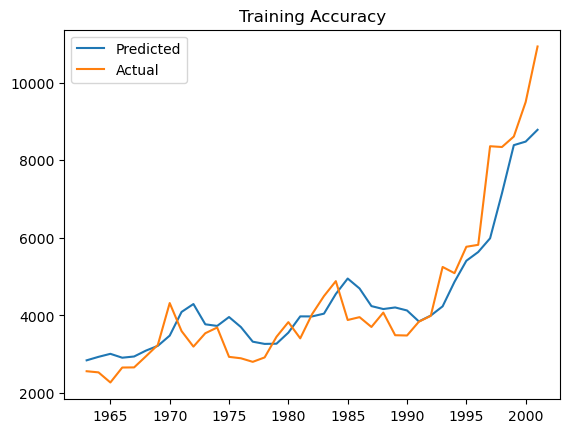

In [434]:
plt.plot(train_data_year[window_size+1:], train_predict.flatten())
plt.plot(train_data_year[window_size+1:], scaler.inverse_transform(y_train.reshape(-1, 1)))
plt.legend(['Predicted', 'Actual'])
plt.title('Training Accuracy')

In [435]:
val_predict = best_model.predict(X_val)
val_predict = scaler.inverse_transform(val_predict)
val_predict

1/1 [==============================] - 0s 23ms/step


array([[10053.547],
       [10402.245],
       [10738.279],
       [10708.954],
       [10541.633],
       [10690.499],
       [10389.619],
       [10411.176],
       [11074.814],
       [11960.236],
       [11856.565],
       [11868.243],
       [13226.766],
       [14265.295],
       [14969.576]], dtype=float32)

Text(0.5, 1.0, 'Validation Accuracy')

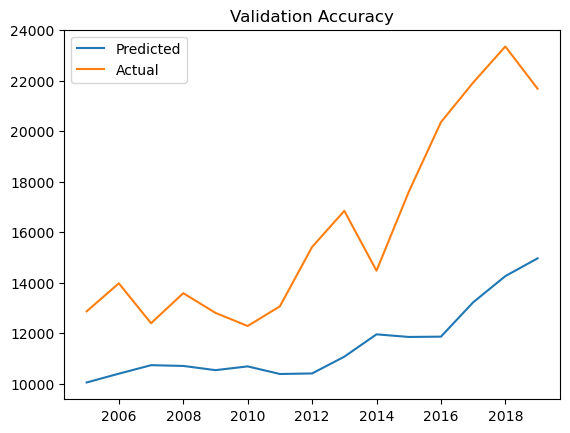

In [436]:
plt.plot(val_data_year[window_size+1:], val_predict.flatten())
plt.plot(val_data_year[window_size+1:], scaler.inverse_transform(y_val.reshape(-1, 1)))
plt.legend(['Predicted', 'Actual'])
plt.title('Validation Accuracy')

<h2>CO<sub>2</sub> prediction for next 5 years</h2>
In order to predict next 10 years, we have to start with last 5 (window_size) records of the dataset and predict future values one by one.

In [437]:
val_data

array([[0.42428668],
       [0.47168195],
       [0.49305629],
       [0.5446335 ],
       [0.47121728],
       [0.5265118 ],
       [0.49026836],
       [0.46610604],
       [0.50234947],
       [0.61154451],
       [0.67799085],
       [0.56786648],
       [0.71284033],
       [0.8410864 ],
       [0.91403795],
       [0.98048429],
       [0.90288613],
       [1.        ]])

In [438]:
val_data.shape

(18, 1)

In [439]:
x_input = val_data[-(window_size):].reshape(1, -1)
x_input.shape

(1, 2)

In [440]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [441]:
temp_input

[0.9028861272557324, 1.0]

In [442]:
from numpy import array

lst_output=[]
n_steps=window_size
number_of_years_to_predict = 5
i=0
while(i<number_of_years_to_predict):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} Year input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} Year output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.59165937]
3


<IPython.core.display.Javascript object>

1 Year input [1.         0.59165937]
1 Year output [[0.5338469]]


<IPython.core.display.Javascript object>

2 Year input [0.59165937 0.53384691]
2 Year output [[0.41706842]]


<IPython.core.display.Javascript object>

3 Year input [0.53384691 0.41706842]
3 Year output [[0.37916726]]


<IPython.core.display.Javascript object>

4 Year input [0.41706842 0.37916726]
4 Year output [[0.34227353]]
[[0.5916593670845032], [0.533846914768219], [0.4170684218406677], [0.37916725873947144], [0.3422735333442688]]


### Plot predicted values

In [443]:
year_new = val_data_year[-window_size:] # new year range
year_pred = np.arange(int(year_new[-1:]) + 1, int(year_new[-1:]) + number_of_years_to_predict + 1) # new predicted years

<IPython.core.display.Javascript object>

In [444]:
original_data_from_df = scaler.inverse_transform(df_scaled[(len(df_co2) - window_size):])
original_data_from_predicteds = scaler.inverse_transform(lst_output)

In [445]:
original_data_from_df

array([[21690.00053406],
       [23780.00068665]])

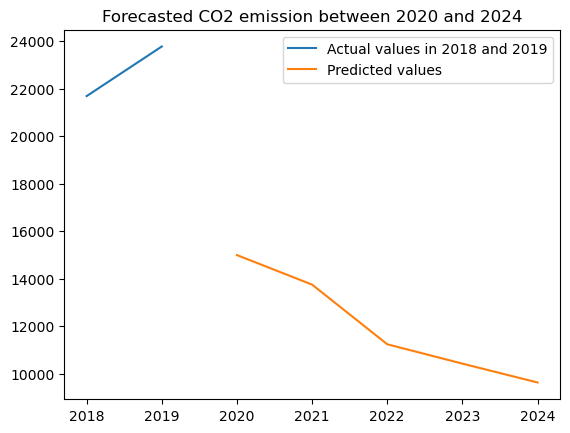

In [446]:
plt.title('Forecasted CO2 emission between 2020 and 2024')
plt.plot(year_new, original_data_from_df)
plt.plot(year_pred, original_data_from_predicteds)
plt.legend(['Actual values in 2018 and 2019', 'Predicted values'])
plt.show()

### Combine predicteds to the original dataset and plot

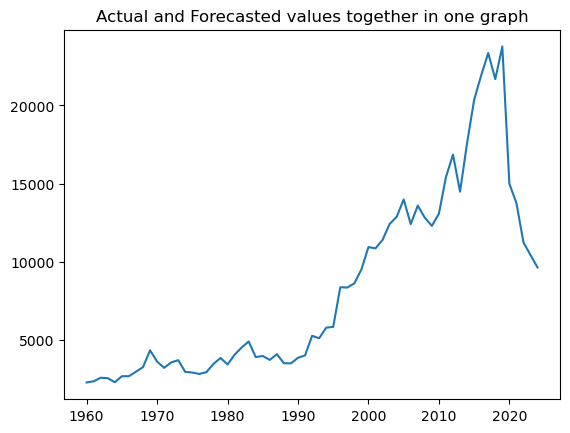

In [447]:
df3 = scaler.inverse_transform(df_scaled).tolist()
df3.extend(scaler.inverse_transform((lst_output)))
df3_year = list(df_year) + list(year_pred)

plt.title('Actual and Forecasted values together in one graph')
plt.plot(df3_year, df3)
plt.show()